# Aggregating and Learning from Multiple Annotators: Practical

This part of the tutorial has the following goals:
   * Learn to use Dawid and Skene (1979) models to aggregate classifications from a crowd.
   * Understand the effect of key hyperparameters in the above models.
   
As an example dataset, we will work with crowdsourced annotations for the _recognising textual entailment (RTE)_ task. This dataset is the PASCAL RTE-1 corpus containing 800 text-hypothesis pairs for which gold annotations were provided by Dagan et al. (2006). Snow et al. (2008) produced the crowdsourced dataset for the corpus:  164 annotators produced 10 annotations for each sentence-pair. 

> Ido  Dagan,  Oren  Glickman,  and  Bernardo  Magnini.2006.  The PASCAL recognising textual entailmentchallenge.In  Juan  Qui ̃nonero-Candela,  Ido  Da-gan, Bernardo Magnini, and F. d’Alch ́e Buc, editors,MLCW 2005, number 3944 in LNAI, pages 177–190.Springer.

> Rion Snow,  Brendan O’Connor,  Daniel Jurafsky,  andAndrew  Y.  Ng.  2008.    Cheap  and  fast  -  but  is  itgood? evaluating non-expert annotations for naturallanguage tasks. InProc. of EMNLP, pages 254–263.

First, we apply a variational Bayesian variant of Dawid & Skene's 1979 method to infer the true labels independently. Then, we train classifiers with both aggregated labels and the raw crowdsourced labels using the CrowdLayer method.

## Importing Required Packages
Please run the notebook containing the directory you cloned from the Github repository.

In [1]:
# pick up any changes to the imported modules automatically
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import numpy as np
import random
from sklearn.metrics import accuracy_score, f1_score, roc_curve, log_loss
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.stats import beta

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# code included in this directory:
import sys
sys.path.append('src')
from bayesian_combination.ibcc import IBCC

## Loading the Data

The following code should show that the data folders 'snow2008_mturk_data_with_orig_files_assembled_201904' and 'all_collected_data' are in the current directory and the 'rte' folder is inside 'snow2008_mturk_data_with_orig_files_assembled_201904'.

In [2]:
print(os.listdir('.'))
print(os.listdir('./snow2008_mturk_data_with_orig_files_assembled_201904'))

rte_text_dir = './snow2008_mturk_data_with_orig_files_assembled_201904/rte'
rte_text_file = os.path.join(rte_text_dir, 'rte1.tsv')
rte_anno_file = './all_collected_data/rte.standardized.tsv'

['snow2008_mturk_data_with_orig_files_assembled_201904', '.DS_Store', 'LICENSE', 'environment.yml', 'aggregation_tutorial.ipynb', 'README.md', '.gitignore', '.ipynb_checkpoints', 'all_collected_data', '.git', 'src']
['.DS_Store', 'tempeval', 'all_collected_data.tgz', 'rte', 'README.txt', 'affect_emotion']


In [4]:
# Load the text.
textdata = pd.read_csv(
    rte_text_file, 
    sep='\t', 
    usecols=[0, 1, 3, 4], 
    index_col=0, 
    names=['item_id', 'gold', 'text', 'hypothesis'],
    skiprows=1
)

# Load the crowdsourced data
crowddata = pd.read_csv(
    rte_anno_file, 
    sep='\t', 
    usecols=[0, 1, 2, 3],
    index_col=0,
    names=['annotation_id', 'worker', 'item_id', 'label'],
    skiprows=1
)

print('Gold-labelled text data: \n')

for column in textdata:
    print(f'>{column}: {textdata[column].iloc[0]}')

print('\n\nCrowdsourced labels: \n')
    
for column in crowddata:
    print(f'>{column}: {crowddata[column].iloc[0]}')

Gold-labelled text data: 

>gold: True
>text: Mexico City has a very bad pollution problem because the mountains around the city act as walls and block in dust and smog.
>hypothesis: Poor air circulation out of the mountain-walled Mexico City aggravates pollution.


Crowdsourced labels: 

>worker: A19IBSKBTABMR3
>item_id: 266
>label: 1


In [5]:
# Put the gold data into a vector
num_items = np.max(textdata.index) + 1

gold_labels = np.zeros(num_items) - 1
gold_labels[textdata.index] = textdata["gold"].astype(int)

print(np.sum(gold_labels==0))
print(np.sum(gold_labels==1))

400
400


In [6]:
# Convert the Amazon MT worker IDs to consecutive numbers
uworkers, worker_ids = np.unique(crowddata["worker"], return_inverse=True)
num_workers = np.max(worker_ids) + 1

# Put the crowdsourced data into matrix format
crowd_matrix = np.zeros((num_items, num_workers)) - 1  # use -1 to indicate missing labels

# fill the matrix
crowd_matrix[crowddata["item_id"].astype(int), worker_ids] = crowddata["label"].astype(int)

print(crowd_matrix)
print(np.sum(crowd_matrix == 0))
print(np.sum(crowd_matrix == 1))

# limit the number of labels per data point to 5
def reduce_num_annotations(crowd_matrix, max_workers_per_item):
    for i in range(num_items):
        row = crowd_matrix[i, :]
        available = np.argwhere(row > -1).flatten()
        if len(available) > max_workers_per_item:
            to_be_removed = available[max_workers_per_item:]
            crowd_matrix[i, to_be_removed] = -1
            
    return crowd_matrix

max_workers_per_item = 3
crowd_matrix = reduce_num_annotations(crowd_matrix, max_workers_per_item)

print(np.unique(np.sum(crowd_matrix > -1, axis=1)))

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  0. -1. ... -1. -1. -1.]]
3419
4581
[0 3]


Let's test some baselines. Firstly, the majority class baseline, then the majority vote.

In [7]:
baseline_predictions = np.zeros(num_items)

total_votes = np.sum(crowd_matrix != -1, axis=1)
votes = np.zeros(num_items)
votes[total_votes > 0] = np.sum(crowd_matrix == 1, axis=1)[total_votes > 0] / total_votes[total_votes > 0].astype(float)

mv_predictions = np.zeros(num_items, dtype=int)
mv_predictions[(total_votes > 0) & (votes>0.5)] = 1

Write a function to compute and show some performance metrics:

In [9]:
def show_metrics(gold_labels, prob_class_1, predicted_labels, method_names):
        
    idxs = gold_labels != -1
    gold_labels = gold_labels[idxs]
        
    for m, method_name in enumerate(method_names):
        print('Method = {}'.format(method_name))
        
        acc = accuracy_score(gold_labels, predicted_labels[m][idxs])
        print('Accuracy = {}'.format(acc))
    
        f1 = f1_score(gold_labels, predicted_labels[m][idxs])
        print('F1 score = {}'.format(f1))
        
        ll = log_loss(gold_labels, prob_class_1[m][idxs])
        print('Cross entropy error = {}'.format(ll))
        
show_metrics(
    gold_labels, 
    [baseline_predictions, votes], 
    [baseline_predictions, mv_predictions], 
    ['majority class', 'majority_vote']
)

Method = majority class
Accuracy = 0.5
F1 score = 0.0
Cross entropy error = 17.269388197455342
Method = majority_vote
Accuracy = 0.67375
F1 score = 0.7350253807106599
Cross entropy error = 2.4307899322636777


## Dawid & Skene (IBCC-VB)

The model we run here is IBCC-VB, which is a modification to the Dawid & Skene (1979) model. The [repository is available here](https://github.com/ukplab/arxiv2018-bayesian-ensembles). For a recap of the model, please [see the tutorial slides](https://sites.google.com/view/alma-tutorial) or the description in [Paun et al. (2018), Comparing Bayesian Models of Annotation](https://transacl.org/ojs/index.php/tacl/article/view/1430).



IBCC-VB differs from the original Dawid & Skene method in the following ways:
   * The parameters have prior distributions -- it is a Bayesian treatment of the model.
   * Approximate inference is performed using variational Bayes instead of maximum likelihood EM.
This has some benefits: 
   * We can include prior information about labeller reliability and class imbalances. This is particularly useful when to avoid the nonidentifiability problem of unsupervised methods by encoding the prior belief that labellers are more likely to give correct answers than incorrect ones.
   * The inference method integrates over unknown parameters, reducing the influence of workers who are known with less confidence. For example, if a worker labels two data points and gets them right, how strongly do we trust them on a third data point? Usually, we would not be very conifdent of their reliability despite a 100% accuracy record.  We may even trust them less than someone who labelled 1000 data points and got 900 right. Bayesian inference takes care of this, whereas maximum likelihood estimation can be led astray by workers who have completed few tasks.

### Run IBCC with a Matrix of Annotations

In [11]:
ibcc_model = IBCC(
    L=2, # number of classes
    K=num_workers, 
)

# Run inference to obtain an array of size num_data_points x num_classes containing the probabilities of the true labels
posterior, ibcc_predictions, _ = ibcc_model.fit_predict(crowd_matrix)

# Compare with the ground truth
show_metrics(
    gold_labels, 
    [baseline_predictions, votes, posterior[:, 1]], 
    [baseline_predictions, mv_predictions, ibcc_predictions], 
    ['majority class', 'majority_vote', 'IBCC-VB']
)

Method = majority class
Accuracy = 0.5
F1 score = 0.0
Cross entropy error = 17.269388197455342
Method = majority_vote
Accuracy = 0.67375
F1 score = 0.7350253807106599
Cross entropy error = 2.4307899322636777
Method = IBCC-VB
Accuracy = 0.83375
F1 score = 0.8372093023255813
Cross entropy error = 0.39417886651400763


## Evaluating Annotators

The IBCC-VB model learns a 'confusion matrix' parameter for each annotator. This parameter describes the reliability of the worker. IBCC-VB provides the expected value of this parameter, as shown in the code below. Each row of the matrix is the likelihood distribution of the annotator's labels given the ground truth. High values on the diagonals indicate an accurate worker.

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


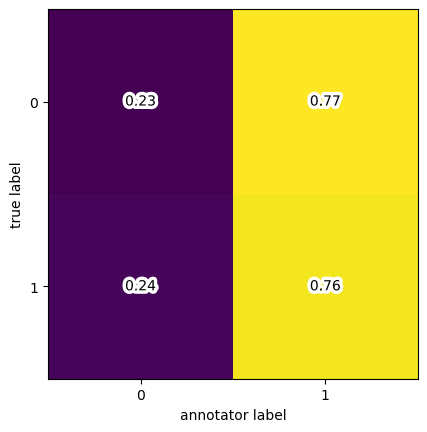

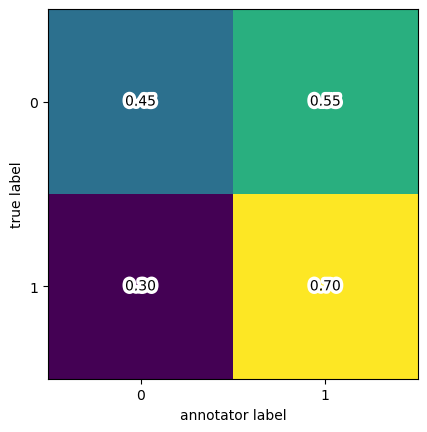

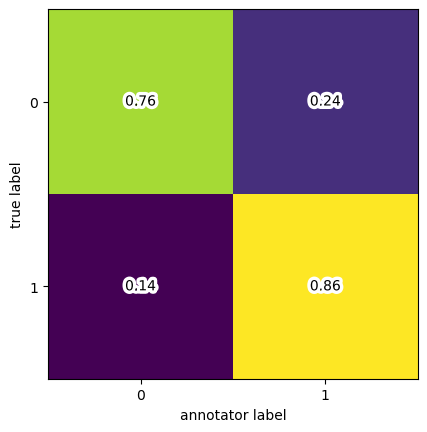

In [12]:
# print the confusion matrix for worker i
def plot_confusion_matrix(model, annotator_idx):
    
    # compute the expected confusion matrix by normalising the alpha variational parameter
    E_conf_mat = model.A.alpha[:, :, annotator_idx] / np.sum(model.A.alpha[:, :, annotator_idx], axis=1)[:, None]
    
    plt.figure()
    plt.imshow(E_conf_mat)
    
    min_val, max_val = 0, model.L
    ind_array_rows = np.arange(min_val, max_val, 1)
    
    min_val, max_val = 0, model.L
    ind_array_cols = np.arange(min_val, max_val, 1)
    
    x, y = np.meshgrid(ind_array_rows, ind_array_cols)

    for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
        text = "%.2f" % E_conf_mat[y_val, x_val]
        txt = plt.text(x_val, y_val, text, va='center', ha='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        
    plt.xlabel('annotator label')
    plt.ylabel('true label')
    plt.yticks([0, 1])
    plt.xticks([0, 1])

        
# Show the results with a selection of annotators:
plot_confusion_matrix(ibcc_model, 0)
plot_confusion_matrix(ibcc_model, 1)
plot_confusion_matrix(ibcc_model, 2)

If we need a single value to assess an annotator's competence, we can compute the mutual information (MI) between the annotators' labels and the ground truth. This value uses information theory to quantify how much we learn about the true label from an annotator's label. In other words the information gain (IG) from the annotation.

Assuming an unlabelled data point, the information gain about a label $c_i$ from annotator $n$'s label, $y_{i,n}$ is:

$$
I(c_i; y_{i,n}) = H(c_{i}) - H(c_i | y_{i,n}) \\
= \sum_{j=1}^J\left\{ - p(c_i=j) \ln p(c_i=j) + \sum_{k=1}^J p(y_{i,n}=k)p(c_i=j | y_{i,n}=k) \ln p(c_i=j | y_{i,n}=k) \right\} \\
= \sum_{j=1}^J \left\{ - p(c_i=j) \ln p(c_i=j) + \sum_{k=1}^J p(y_{i,n}=k | c_i=j)p(c_i=j) \ln \frac{p(y_{i,n}=k | c_i=j)p(c_i=j)}{\sum_{l=1}^J p(y_{i,n}=l | c_i=j)p(c_i=j)} \right\}
$$

where $J$ is the number of classes and $H$ is entropy.

This function is already implemented in the BayesianCombination library:

In [ ]:
I = ibcc_model.informativeness()  # get a list of informativeness scores for all annotators

ranks = np.flip(np.argsort(I))  # sort in descending order

# Print the top annotators' scores and confusion matrices
for i in range(5):
    print("Annotator {} has informativeness score of {}".format(ranks[i], I[ranks[i]]))
#     plot_confusion_matrix(ibcc_model, ranks[i])

### Adjusting the hyperparameters

In IBCC, each worker has a confusion matrix parameter for each worker that determines the likelihood of the worker labels given the true classes. Each row of this matrix, $\boldsymbol\pi_j$, contains the probabilities of a categorical distribution for the case when the true label has value $j$. These probabilities have a Dirichlet prior distribution, $\boldsymbol\pi_j \sim Dirichlet(\boldsymbol\alpha_{0,j})$. The hyperparameter vectors $\boldsymbol\alpha_{0,j}$ are rows of the hyperparameter matrix, $\boldsymbol\alpha$.

By default, the IBCC code sets the values in $\boldsymbol\alpha$ to $1$ on the off-diagonals and 2 on the diagonals. Larger values on the diagonals increase the probability that workers tend to give the right answer, because the diagonals correspond to giving correct answers.

However, we can set $\boldsymbol\alpha$ to any suitable values for a particular domain. 

The model also has a hyperparameter $\boldsymbol\beta_0$ that also parametrises a Dirichlet distribution over the class prior. Adjusting this encodes the prior belief in the balance between the two classes.

To understand the effects of $\boldsymbol\alpha_0$ and $\boldsymbol\beta_0$, let's first visualise the Dirichlet distribution to see how it maps $\boldsymbol\alpha_{0,j}$ to a distribution over probabilities. In our use case, we have only two classes, so we can work with the binary special case of the Dirichlet known as the Beta distribution. For the binary case, we compute the probability density function over p(class 1) only, since p(class 0) = 1 - p(class 1).

In [ ]:
#First, let's plot some beta distriutions for different parameters:

plt.figure()
plt.title('Uncertainty over whether a worker is accurate or not')

x = np.arange(101) / 100.0
y = beta.pdf(x, 1, 1)
plt.plot(x,y, label='1, 1: noninformative prior -- no prior knowledge')

y = beta.pdf(x, 0.1, 0.1)
plt.plot(x,y, label='0.1, 0.1: extreme, but uncertain which extreme')

y = beta.pdf(x, 0.8, 0.8)
plt.plot(x,y, label='0.8, 0.8: bias to the extremes')

plt.legend(loc='best')


plt.figure()
plt.title('Weak priori belief that the worker is accurate')

y = beta.pdf(x, 1, 0.1)
plt.plot(x,y, label='1, 1.1')

y = beta.pdf(x, 2, 1)
plt.plot(x,y, label='1, 2')

y = beta.pdf(x, 10, 9)
plt.plot(x,y, label=', 5')


plt.figure()
plt.title('Strong priori belief that the worker is accurate')

y = beta.pdf(x, 1, 0.1)
plt.plot(x,y, label='1, 0.1')

y = beta.pdf(x, 10, 1)
plt.plot(x,y, label='10, 1')

y = beta.pdf(x, 10, 5)
plt.plot(x,y, label='10, 5')

y = beta.pdf(x, 100, 50)
plt.plot(x,y, label='100, 50')

plt.legend(loc='best')

Now, we can plot performance (prec, rec, f1) as we vary $\boldsymbol\alpha_0$ then $\boldsymbol\beta_0$. To reduce the number of hyperparameters we have to vary, we are going to consider just two values: a value that is first assigned to all entries, and a value that is added to all diagonals.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def run_ibcc(diagonals, base, beta0, gold_labels, crowd_matrix):

    ibcc_model = IBCC(
        L=2, # number of classes
        K=num_workers, 
        alpha0_factor=base,
        alpha0_diags=diagonals,
        beta0_factor=beta0
    )

    # Run inference to obtain an array of size num_data_points x num_classes containing the probabilities of the true labels
    posterior, predictions, _ = ibcc_model.fit_predict(crowd_matrix)
    
    idxs = gold_labels != -1
    acc = accuracy_score(gold_labels[idxs], predictions[idxs])
    f1 = f1_score(gold_labels[idxs], predictions[idxs])
    
    return acc, f1

range_diagonals = np.array([0.01, 0.1, 1, 10, 100])
range_base = np.array([0.01, 0.1, 1, 10, 100])

results_acc = np.zeros((len(range_base), len(range_diagonals)))
results_f1 = np.zeros((len(range_base), len(range_diagonals)))

for i, o in enumerate(range_base):
    for j, d in enumerate(range_diagonals):
        acc, f1 = run_ibcc(d, o, 1, gold_labels, crowd_matrix)
        
        results_acc[i, j] = acc
        results_f1[i, j] = f1

# bestbase, bestdiag = np.unravel_index(np.argmax(results_acc), (len(range_base), len(range_diagonals)))
# print('Best results: base value={}, diagonal={}, accuracy={}'.format(
#     range_base[bestbase],
#     range_diagonals[bestdiag],
#     results_acc[bestbase, bestdiag]
# ) )
        
bestbase, bestdiag = np.unravel_index(np.argmax(results_f1), (len(range_base), len(range_diagonals)))
print('Best results: base value={}, diagonal={}, F1 score={}'.format(
    range_base[bestbase],
    range_diagonals[bestdiag],
    results_f1[bestbase, bestdiag]
) )
  
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(
#     np.tile(np.log10(range_base)[None, :], (len(range_diagonals), 1)), 
#     np.tile(np.log10(range_diagonals)[:, None], (1, len(range_base))), 
#     results_acc,
#     cmap=cm.coolwarm,
#     linewidth=0, 
#     antialiased=False
# )

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    np.tile(np.log10(range_base)[None, :], (len(range_diagonals), 1)), 
    np.tile(np.log10(range_diagonals)[:, None], (1, len(range_base))), 
    results_f1,
    cmap=cm.coolwarm,
    linewidth=0, 
    antialiased=False
)

In [ ]:
# Do it again, this time varying beta0 and keeping alpha0 fixed
range_proportions = np.array([0.01, 0.1, 1, 10, 100])

results_acc = np.zeros(len(range_proportions))
results_f1 = np.zeros(len(range_proportions))

for i, p in enumerate(range_proportions):
    acc, f1 = run_ibcc(1, 1, p, gold_labels, crowd_matrix)

    results_acc[i] = acc
    results_f1[i] = f1

bestbeta = np.argmax(results_acc)
print('Best results: beta0={}, accuracy={}'.format(
    range_proportions[bestbeta],
    results_acc[bestbeta]
) )
        
bestbeta = np.argmax(results_f1)
print('Best results: beta0={}, F1 score={}'.format(
    range_proportions[bestbeta],
    results_f1[bestbeta]
) )
  
fig = plt.figure()
plt.plot(
    np.log10(range_proportions),
    results_f1,
    label='f1'
)
plt.plot(
    np.log10(range_proportions),
    results_acc,
    label='accuracy'
)

plt.legend(loc='best')

